Now we will work with the [fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). `Fashion-MNIST` is a dataset of [Zalando](https://jobs.zalando.com/tech/)'s article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend `Fashion-MNIST` to serve as a direct **drop-in replacement** for the original [MNIST dataset](http://yann.lecun.com/exdb/mnist/) for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Here's an example of how the data looks (*each class takes three-rows*):

![](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

We start by loading the *Fashion-MNIST* dataset using the `mnist` class from the `keras.datasets` module. We will later build our model using the `Sequential()` class of the `keras.models` module. To do this, we will add dense layers to our `model` object.

In [1]:
#!pip install scikeras

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import optimizers
from scikeras.wrappers import KerasClassifier

In the following, we'll load the dataset and do some data preprocessing. As we'll see, each image is represented as 28x28 pixel data. This is a two-dimensional vector. We'll convert this to a vector of length 784, which will be single-dimensional. We'll also normalize each vector by dividing each element by 255 (which is the maximum value of the RGB color scale).

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

input_dim = 784  # 28*28
output_dim = nb_classes = 10
batch_size = 128
nb_epoch = 20

X_train = X_train.reshape(60000, input_dim)
X_test = X_test.reshape(10000, input_dim)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Next, we'll *one-hot code* our *target variable* using the `to_categorical()` function from the `keras.utils` module:

In [4]:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

Now, check the size of the dataset:

In [5]:
X_train[0].shape

(784,)

As you can see, the size of each image is 784. In fact, all images in *Fashion-MNIST* are 28 by 28 pixels, and 784 is just the result of multiplying 28 by 28. So, the data that you have is a flattened version of the images, where each row in the 28x28 matrix is concatenated side by side.

Now, plot some images and see what they look like:


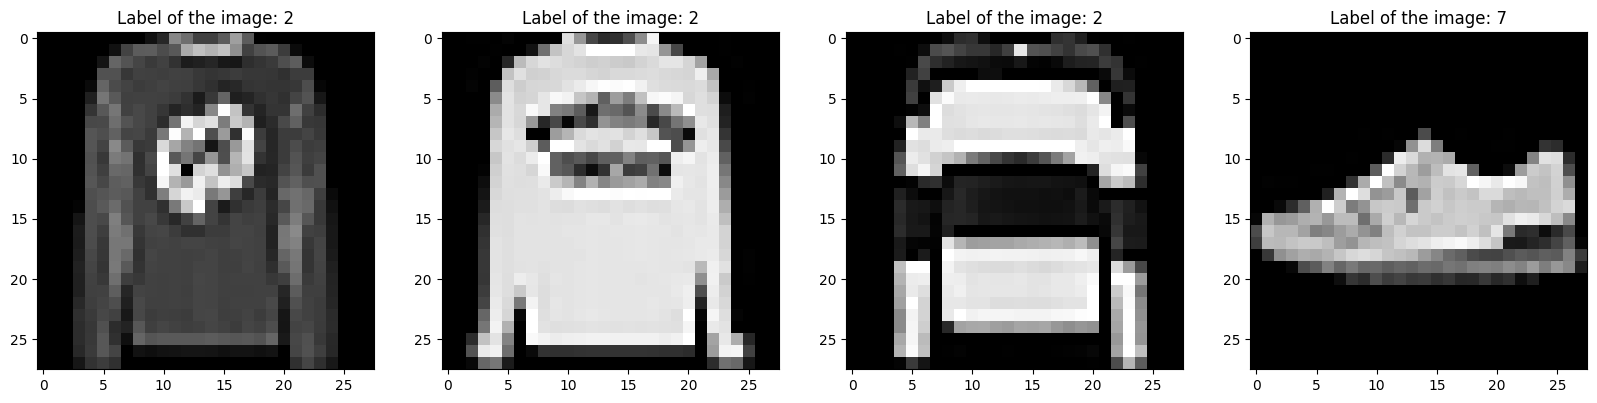

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))

plt.subplot(141)
plt.imshow(X_train[123].reshape(28,28), cmap="gray")
plt.title("Label of the image: {}".format(y_train[123]))

plt.subplot(142)
plt.imshow(X_train[124].reshape(28,28), cmap="gray")
plt.title("Label of the image: {}".format(y_train[124]))

plt.subplot(143)
plt.imshow(X_train[125].reshape(28,28), cmap="gray")
plt.title("Label of the image: {}".format(y_train[125]))

plt.subplot(144)
plt.imshow(X_train[126].reshape(28,28), cmap="gray")
plt.title("Label of the image: {}".format(y_train[126]))

plt.show()

Next, we will test several ANN models through training them on our training set. In particular, we will investigate performance for:

*   Different number of layers
*   Different activation functions in the layers
*   Different number of neurons in the layers
*   Different batch sizes during training
*   Different learning rates

To do this, we will use [GridSearchCV](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) which can be parallelized by setting `n_jobs=-1`.


First, we will tune the training optimization algorithm.

In [7]:
def create_model():
  # create model
  model = Sequential()
  # The first dense layer
  model.add(Dense(128, input_shape=(784,), activation="relu"))
  # The second dense layer
  model.add(Dense(64, activation="relu"))
  # The third dense layer
  model.add(Dense(32, activation="relu"))
  # The last layer is the output layer
  model.add(Dense(10, activation="softmax"))

  return model

def summarize_results():
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [8]:
# create model
model = KerasClassifier(model=create_model, loss="categorical_crossentropy",
                        epochs=20, batch_size=batch_size, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
summarize_results()

Best: 0.889117 using {'optimizer': 'Nadam'}
0.851900 (0.003635) with: {'optimizer': 'SGD'}
0.886517 (0.007216) with: {'optimizer': 'RMSprop'}
0.811033 (0.001857) with: {'optimizer': 'Adagrad'}
0.613883 (0.007994) with: {'optimizer': 'Adadelta'}
0.888400 (0.003125) with: {'optimizer': 'Adam'}
0.881900 (0.005678) with: {'optimizer': 'Adamax'}
0.889117 (0.001280) with: {'optimizer': 'Nadam'}


Let's go with the Adam optimizer. Next, we will tune the learning rate.

In [10]:
# define the grid search parameters
optimizer = ['Adam']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(optimizer=optimizer,optimizer__learning_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# summarize results
summarize_results()

Best: 0.886900 using {'optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.886900 (0.005675) with: {'optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.876983 (0.002978) with: {'optimizer': 'Adam', 'optimizer__learning_rate': 0.01}
0.338567 (0.117617) with: {'optimizer': 'Adam', 'optimizer__learning_rate': 0.1}
0.100000 (0.000000) with: {'optimizer': 'Adam', 'optimizer__learning_rate': 0.2}
0.100000 (0.000000) with: {'optimizer': 'Adam', 'optimizer__learning_rate': 0.3}
